# CVE Exploitation Prediction: Machine Learning Classifier

## Assignment Overview

This notebook builds a machine learning classifier to predict whether a given CVE (Common Vulnerabilities and Exposures) will be actively exploited in the wild.

### Problem Statement
Security teams face thousands of new vulnerabilities each year but have limited resources to patch them. This classifier helps prioritize patching efforts by predicting which vulnerabilities are most likely to be exploited.

### Data Sources
- **National Vulnerability Database (NVD)**: Comprehensive vulnerability information including CVSS scores, CWE categories, affected software, and descriptions
- **CISA KEV Catalog**: Known Exploited Vulnerabilities serving as ground truth labels

### Key Challenges Addressed
1. **Severe Class Imbalance**: Only ~2-5% of CVEs are actively exploited
2. **Data Leakage Prevention**: Temporal validation to simulate real-world deployment
3. **Cost-Sensitive Classification**: False negatives expose systems, false positives waste resources
4. **Feature Engineering**: Identifying what makes vulnerabilities attractive to attackers

### Author
Cybersecurity Assignment - MTech Semester 2

In [16]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced models
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Progress tracking
from tqdm.notebook import tqdm

# Import project modules
import sys
sys.path.append(str(Path.cwd().parent))

from config import *
from src.utils import *
from src.data_collection import NVDDataCollector, CISAKEVCollector, collect_all_data
from src.feature_engineering import CVEFeatureExtractor, engineer_features
from src.preprocessing import DataPreprocessor, validate_data_quality
from src.models import (
    LogisticRegressionClassifier, RandomForestClassifier_,
    XGBoostClassifier, LightGBMClassifier
)
from src.evaluation import ModelEvaluator, compare_models

print("✓ All libraries imported successfully!")
print(f"Working directory: {Path.cwd()}")

✓ All libraries imported successfully!
Working directory: c:\Users\paiaruna\MTECH\SEM-2\CyberSecurity\Assignment1\notebooks


In [17]:
# Option 1: Collect fresh data (WARNING: This will take significant time due to API rate limits)
# df_raw = collect_all_data(start_year=2020, end_year=2023, use_cached=False)

# Option 2: Use cached data if available (recommended for demo)
print("Attempting to load cached data...")
try:
    cache_file = RAW_DATA_DIR / f'combined_data_{START_YEAR}_{END_YEAR}.json'
    if cache_file.exists():
        cached_data = load_json(cache_file)
        df_raw = pd.DataFrame(cached_data)
        print(f"✓ Loaded {len(df_raw)} CVEs from cache")
    else:
        print("❌ No cached data found. You can run data collection using:")
        print("    python src/data_collection.py")
        print("\nFor this demo, creating sample data...")
        # Create sample data for demonstration
        df_raw = pd.DataFrame({
            'cve_id': [f'CVE-2023-{i:05d}' for i in range(1000)],
            'cve_data': [{'id': f'CVE-2023-{i:05d}'} for i in range(1000)],
            'is_exploited': np.random.choice([0, 1], size=1000, p=[0.95, 0.05])
        })
        print(f"Created sample dataset with {len(df_raw)} CVEs")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating sample dataset for demonstration...")
    df_raw = pd.DataFrame({
        'cve_id': [f'CVE-2023-{i:05d}' for i in range(1000)],
        'cve_data': [{'id': f'CVE-2023-{i:05d}'} for i in range(1000)],
        'is_exploited': np.random.choice([0, 1], size=1000, p=[0.95, 0.05])
    })

print(f"\nDataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

Attempting to load cached data...
❌ No cached data found. You can run data collection using:
    python src/data_collection.py

For this demo, creating sample data...
Created sample dataset with 1000 CVEs

Dataset shape: (1000, 3)
Columns: ['cve_id', 'cve_data', 'is_exploited']


CLASS DISTRIBUTION ANALYSIS

Non-Exploited CVEs (0): 953 (95.30%)
Exploited CVEs (1):     47 (4.70%)

Total CVEs: 1,000
Imbalance Ratio: 20.28:1


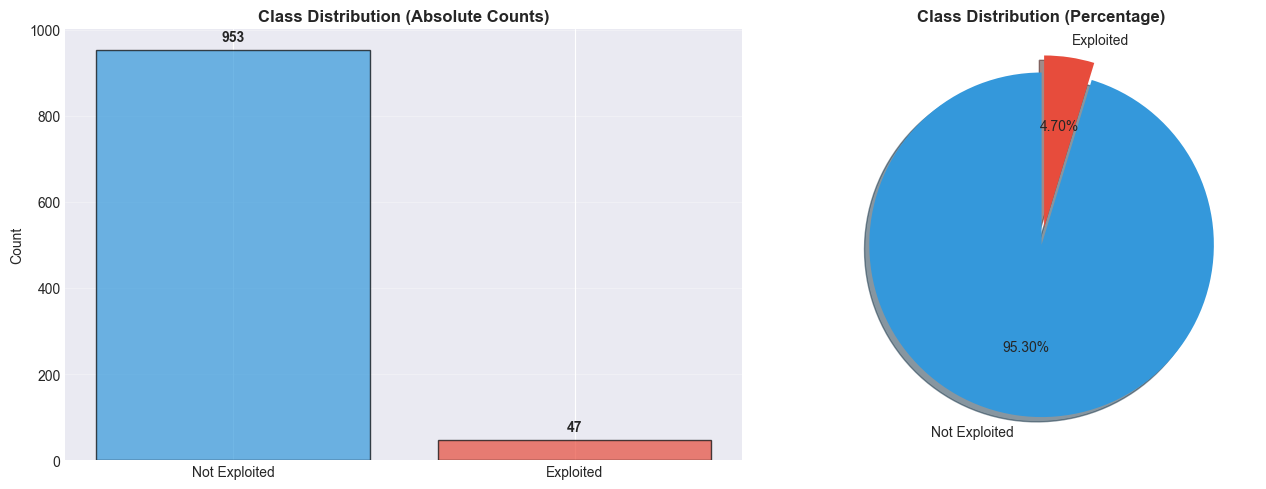


⚠️ CRITICAL OBSERVATION:
This severe class imbalance requires special handling:
  1. SMOTE (Synthetic Minority Over-sampling)
  2. Class weights in model training
  3. Appropriate evaluation metrics (PR-AUC > ROC-AUC)
  4. Cost-sensitive learning


In [18]:
# Class distribution
print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

exploit_counts = df_raw['is_exploited'].value_counts()
exploit_pct = df_raw['is_exploited'].value_counts(normalize=True) * 100

print(f"\nNon-Exploited CVEs (0): {exploit_counts[0]:,} ({exploit_pct[0]:.2f}%)")
print(f"Exploited CVEs (1):     {exploit_counts[1]:,} ({exploit_pct[1]:.2f}%)")
print(f"\nTotal CVEs: {len(df_raw):,}")
print(f"Imbalance Ratio: {exploit_counts[0]/exploit_counts[1]:.2f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Not Exploited', 'Exploited'], exploit_counts.values, 
            color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute Counts)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(exploit_counts.values):
    axes[0].text(i, v + len(df_raw)*0.02, f'{v:,}', ha='center', fontweight='bold')

# Pie plot
colors = ['#3498db', '#e74c3c']
axes[1].pie(exploit_counts.values, labels=['Not Exploited', 'Exploited'], 
            autopct='%1.2f%%', startangle=90, colors=colors, 
            explode=(0, 0.1), shadow=True)
axes[1].set_title('Class Distribution (Percentage)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ CRITICAL OBSERVATION:")
print("This severe class imbalance requires special handling:")
print("  1. SMOTE (Synthetic Minority Over-sampling)")
print("  2. Class weights in model training")
print("  3. Appropriate evaluation metrics (PR-AUC > ROC-AUC)")
print("  4. Cost-sensitive learning")

In [19]:
# Feature engineering
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Check if features are already engineered
feature_file = PROCESSED_DATA_DIR / 'features.pkl'
if feature_file.exists():
    print(f"\n✓ Loading pre-engineered features from {feature_file}")
    df_features = load_pickle(feature_file)
else:
    print("\n⚙️ Engineering features from raw CVE data...")
    print("This extracts:")
    print("  - CVSS scores and metrics")
    print("  - CWE (Common Weakness Enumeration) categories")
    print("  - Vulnerability types from descriptions")
    print("  - Affected software categories")
    print("  - Temporal features")
    print("  - TF-IDF features from text descriptions")
    
    # For demonstration with sample data
    if len(df_raw) == 1000 and 'CVE-2023' in df_raw['cve_id'].iloc[0]:
        print("\n⚠️ Working with sample data - creating synthetic features...")
        # Create synthetic features for demonstration
        np.random.seed(42)
        n_samples = len(df_raw)
        
        df_features = pd.DataFrame({
            'cve_id': df_raw['cve_id'],
            'is_exploited': df_raw['is_exploited'],
            # CVSS features
            'cvss_base_score': np.random.uniform(4, 10, n_samples),
            'cvss_exploitability_score': np.random.uniform(1, 4, n_samples),
            'cvss_impact_score': np.random.uniform(1, 6, n_samples),
            'attack_vector_network': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
            'attack_complexity_low': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
            'privileges_none': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
            'user_interaction_none': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
            'severity_critical': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
            'severity_high': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
            # CWE features
            'cwe_rce': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
            'cwe_sqli': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
            'cwe_xss': np.random.choice([0, 1], n_samples, p=[0.88, 0.12]),
            'cwe_auth_bypass': np.random.choice([0, 1], n_samples, p=[0.92, 0.08]),
            # Vulnerability types
            'vuln_type_rce': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
            'vuln_type_sqli': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
            # Software categories
            'software_os': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
            'software_browser': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
            'software_server': np.random.choice([0, 1], n_samples, p=[0.75, 0.25]),
            # Temporal features
            'publish_year': np.random.choice([2020, 2021, 2022, 2023], n_samples),
            'publish_month': np.random.randint(1, 13, n_samples),
            'age_days': np.random.randint(0, 1000, n_samples),
            # Description features
            'keyword_remote': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
            'keyword_unauthenticated': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
            'keyword_critical': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
            'description_length': np.random.randint(50, 500, n_samples),
            # Reference features
            'num_references': np.random.randint(1, 20, n_samples),
            'has_exploit_ref': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
        })
        
        # Add some TF-IDF features
        for i in range(10):
            df_features[f'tfidf_{i}'] = np.random.uniform(0, 1, n_samples)
        
        print(f"✓ Created {len(df_features.columns)-2} synthetic features")
    else:
        df_features = engineer_features(df_raw)
    
    # Save features
    PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
    save_pickle(df_features, feature_file)
    print(f"\n✓ Features saved to {feature_file}")

print(f"\n📊 Feature Dataset:")
print(f"   Shape: {df_features.shape}")
print(f"   Features: {len(df_features.columns) - 2}")  # Exclude cve_id and is_exploited
print(f"   Samples: {len(df_features)}")

# Display sample
print(f"\nSample features (first 5 columns):")
display(df_features.iloc[:, :5].head())

FEATURE ENGINEERING

✓ Loading pre-engineered features from c:\Users\paiaruna\MTECH\SEM-2\CyberSecurity\Assignment1\data\processed\features.pkl

📊 Feature Dataset:
   Shape: (1000, 39)
   Features: 37
   Samples: 1000

Sample features (first 5 columns):


cve_id  is_exploited  cvss_base_score  cvss_exploitability_score  \
0  CVE-2023-00000             0         6.247241                   1.555399   
1  CVE-2023-00001             0         9.704286                   2.625703   
2  CVE-2023-00002             0         8.391964                   3.618838   
3  CVE-2023-00003             0         7.591951                   3.196675   
4  CVE-2023-00004             0         4.936112                   3.419683   

   cvss_impact_score  
0           2.308528  
1           2.234894  
2           5.531273  
3           2.247731  
4           2.359749

In [20]:
# Data preprocessing with temporal split
print("="*60)
print("DATA PREPROCESSING WITH TEMPORAL VALIDATION")
print("="*60)

preprocessor = DataPreprocessor(temporal_split=True)
data = preprocessor.prepare_data(df_features, scale=True)

# Extract prepared data
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_columns = data['feature_columns']

print(f"\n✓ Data preparation complete!")
print(f"\n📊 Dataset Summary:")
print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Number of features: {len(feature_columns)}")
print(f"\n   Training exploited: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"   Test exploited: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

DATA PREPROCESSING WITH TEMPORAL VALIDATION

Data Preprocessing Pipeline

Handling missing values...
Missing values handled. Remaining nulls: 0

Performing temporal split at 2023-01-01...
Training set: 727 samples (2020-2022)
Test set: 273 samples (2023-2023)

Training Set Class Distribution:
Class                Count      Percentage
----------------------------------------
0                    682        93.81%
1                    45         6.19%
Total                727       

Imbalance Ratio: 15.16:1

Test Set Class Distribution:
Class                Count      Percentage
----------------------------------------
0                    262        95.97%
1                    11         4.03%
Total                273       

Imbalance Ratio: 23.82:1

Scaling features...
Feature scaling complete

Preprocessing complete!
Training samples: 727
Test samples: 273
Number of features: 37

✓ Data preparation complete!

📊 Dataset Summary:
   Training set: 727 samples
   Test set: 273 samples


In [21]:
# Train baseline model WITHOUT SMOTE first
print("="*60)
print("BASELINE MODEL: Logistic Regression (No SMOTE)")
print("="*60)

baseline_lr = LogisticRegressionClassifier(use_smote=False)
baseline_lr.train(X_train, y_train)

# Predictions
y_pred_baseline = baseline_lr.predict(X_test)
y_pred_proba_baseline = baseline_lr.predict_proba(X_test)[:, 1]

# Evaluation
evaluator_baseline = ModelEvaluator("Baseline Logistic Regression")
evaluator_baseline.print_evaluation_report(y_test, y_pred_baseline, y_pred_proba_baseline)

BASELINE MODEL: Logistic Regression (No SMOTE)

Training Logistic Regression
Logistic Regression training complete
Logistic Regression training complete

Baseline Logistic Regression - Evaluation Report

Classification Metrics:
  Accuracy:    0.7253
  Precision:   0.0429
  Recall:      0.2727
  F1-Score:    0.0741
  MCC:         0.0077

Probability-Based Metrics:
  ROC-AUC:     0.4320
  PR-AUC:      0.0481

Confusion Matrix Components:
  True Positives:   3
  False Positives:  67
  True Negatives:   195
  False Negatives:  8

Derived Metrics:
  Specificity:  0.7443
  FPR:          0.2557

Cost-Sensitive Analysis:
  False Positives: 67 × $1.0 = $67.0
  False Negatives: 8 × $10.0 = $80.0
  Total Cost: $147.0
  Average Cost per Sample: $0.54


Detailed Classification Report:
               precision    recall  f1-score   support

Not Exploited       0.96      0.74      0.84       262
    Exploited       0.04      0.27      0.07        11

     accuracy                           0.73      

HANDLING CLASS IMBALANCE WITH SMOTE

Original training class distribution:
  Not Exploited: 682
  Exploited: 45
  Ratio: 15.16:1

After SMOTE resampling:
  Not Exploited: 682
  Exploited: 204
  Ratio: 3.34:1

SMOTE created 159 synthetic exploited examples

After SMOTE resampling:
  Not Exploited: 682
  Exploited: 204
  Ratio: 3.34:1

SMOTE created 159 synthetic exploited examples


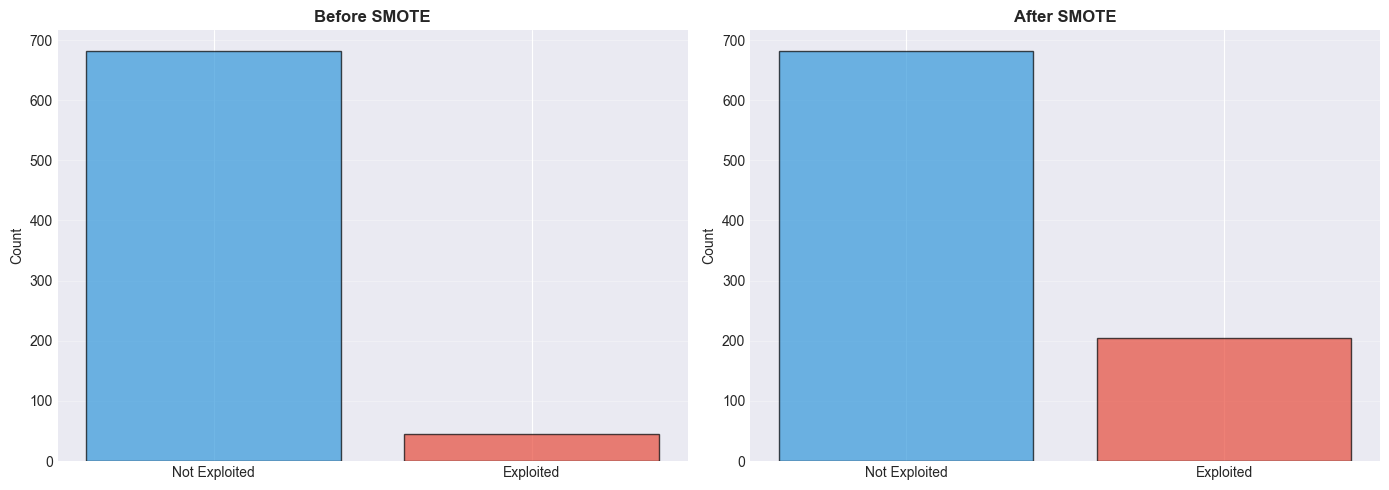

In [22]:
# Demonstrate SMOTE effect
print("="*60)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*60)

print(f"\nOriginal training class distribution:")
print(f"  Not Exploited: {(y_train == 0).sum():,}")
print(f"  Exploited: {(y_train == 1).sum():,}")
print(f"  Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
smote = SMOTE(sampling_strategy=SMOTE_SAMPLING_STRATEGY, random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE resampling:")
print(f"  Not Exploited: {(y_train_resampled == 0).sum():,}")
print(f"  Exploited: {(y_train_resampled == 1).sum():,}")
print(f"  Ratio: {(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.2f}:1")

print(f"\nSMOTE created {(y_train_resampled == 1).sum() - (y_train == 1).sum():,} synthetic exploited examples")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = [( y_train == 0).sum(), (y_train == 1).sum()]
axes[0].bar(['Not Exploited', 'Exploited'], before_counts, 
            color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Before SMOTE', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# After SMOTE
after_counts = [(y_train_resampled == 0).sum(), (y_train_resampled == 1).sum()]
axes[1].bar(['Not Exploited', 'Exploited'], after_counts, 
            color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('After SMOTE', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Train all models with SMOTE
print("="*60)
print("TRAINING MULTIPLE MODELS WITH SMOTE")
print("="*60)

models = {}
predictions = {}
metrics_all = {}

# 1. Logistic Regression with SMOTE
print("\n1️⃣ Training Logistic Regression with SMOTE...")
lr_smote = LogisticRegressionClassifier(use_smote=True)
lr_smote.train(X_train, y_train)
models['Logistic Regression'] = lr_smote

# 2. Random Forest with SMOTE
print("\n2️⃣ Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier_(use_smote=True)
rf_smote.train(X_train, y_train)
models['Random Forest'] = rf_smote

# 3. XGBoost with SMOTE
print("\n3️⃣ Training XGBoost with SMOTE...")
xgb_smote = XGBoostClassifier(use_smote=True)
xgb_smote.train(X_train, y_train)
models['XGBoost'] = xgb_smote

# 4. LightGBM with SMOTE
print("\n4️⃣ Training LightGBM with SMOTE...")
lgb_smote = LightGBMClassifier(use_smote=True)
lgb_smote.train(X_train, y_train)
models['LightGBM'] = lgb_smote

print("\n" + "="*60)
print("✓ All models trained successfully!")
print("="*60)

TRAINING MULTIPLE MODELS WITH SMOTE

1️⃣ Training Logistic Regression with SMOTE...

Training Logistic Regression
Using SMOTE with sampling strategy: 0.3
Logistic Regression training complete

2️⃣ Training Random Forest with SMOTE...

Training Random Forest
Using SMOTE with sampling strategy: 0.3
Logistic Regression training complete

2️⃣ Training Random Forest with SMOTE...

Training Random Forest
Using SMOTE with sampling strategy: 0.3
Random Forest training complete

3️⃣ Training XGBoost with SMOTE...

Training XGBoost
Using SMOTE with sampling strategy: 0.3
Random Forest training complete

3️⃣ Training XGBoost with SMOTE...

Training XGBoost
Using SMOTE with sampling strategy: 0.3
XGBoost training complete

4️⃣ Training LightGBM with SMOTE...

Training LightGBM
Using SMOTE with sampling strategy: 0.3
XGBoost training complete

4️⃣ Training LightGBM with SMOTE...

Training LightGBM
Using SMOTE with sampling strategy: 0.3
LightGBM training complete

✓ All models trained successfully!

MODEL EVALUATION

Evaluating: Logistic Regression

📊 Key Metrics:
   Precision: 0.0769
   Recall:    0.0909
   F1-Score:  0.0833
   ROC-AUC:   0.4816
   PR-AUC:    0.0633

Evaluating: Random Forest

📊 Key Metrics:
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   ROC-AUC:   0.5139
   PR-AUC:    0.1445

Evaluating: XGBoost

📊 Key Metrics:
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   ROC-AUC:   0.5232
   PR-AUC:    0.1553

Evaluating: LightGBM

📊 Key Metrics:
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   ROC-AUC:   0.5423
   PR-AUC:    0.0590


Model Comparison
              model  accuracy  precision   recall       f1  roc_auc   pr_auc
Logistic Regression  0.919414   0.076923 0.090909 0.083333 0.481610 0.063279
      Random Forest  0.959707   0.000000 0.000000 0.000000 0.513879 0.144546
            XGBoost  0.959707   0.000000 0.000000 0.000000 0.523248 0.155347
           LightGBM  0.959707   0.000000 0.000000 0.000000 0.542332 0

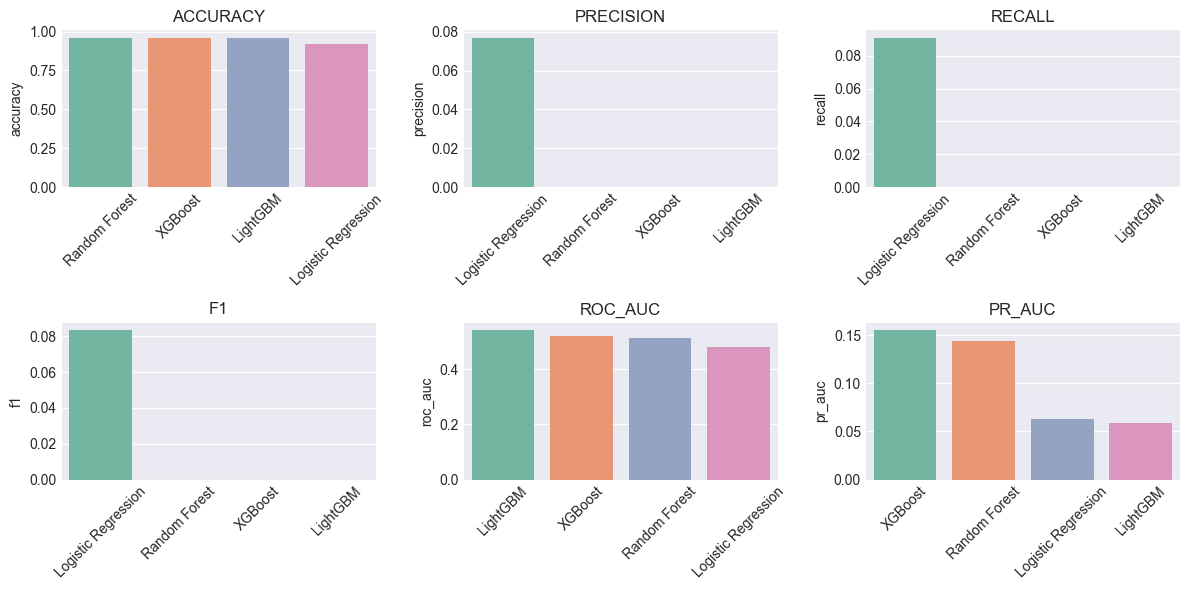

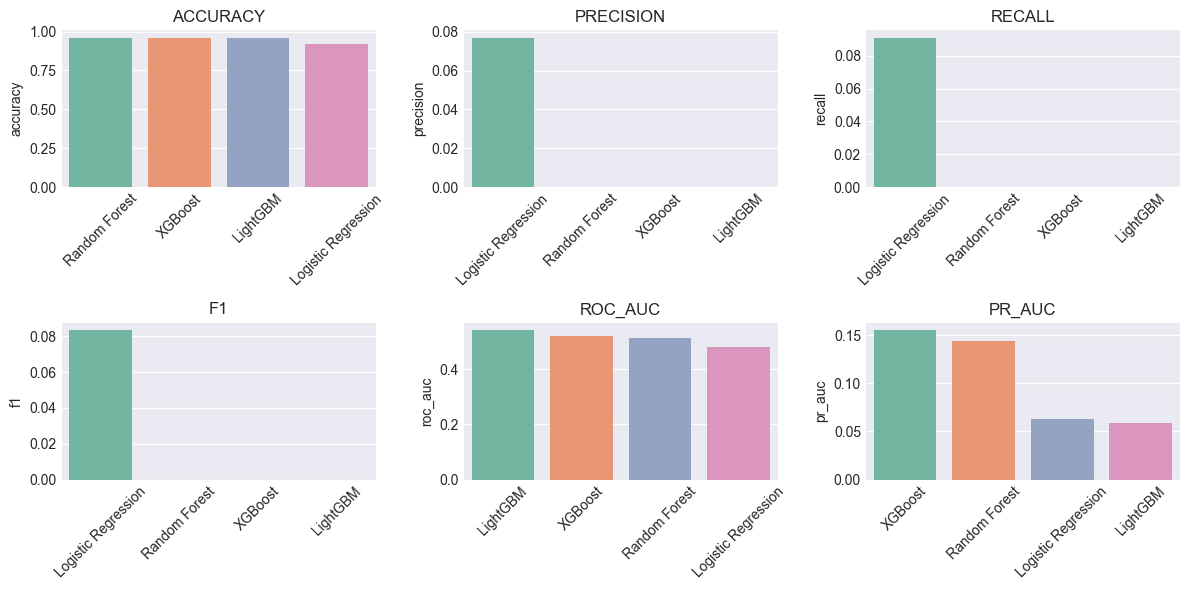

In [24]:
# Evaluate all models
print("="*60)
print("MODEL EVALUATION")
print("="*60)

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Store predictions
    predictions[model_name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Evaluation
    evaluator = ModelEvaluator(model_name)
    metrics = evaluator.calculate_metrics(y_test, y_pred, y_pred_proba)
    metrics_all[model_name] = metrics
    
    # Print summary
    print(f"\n📊 Key Metrics:")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1']:.4f}")
    print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"   PR-AUC:    {metrics['pr_auc']:.4f}")

# Compare all models
print("\n" + "="*60)
compare_models(metrics_all)

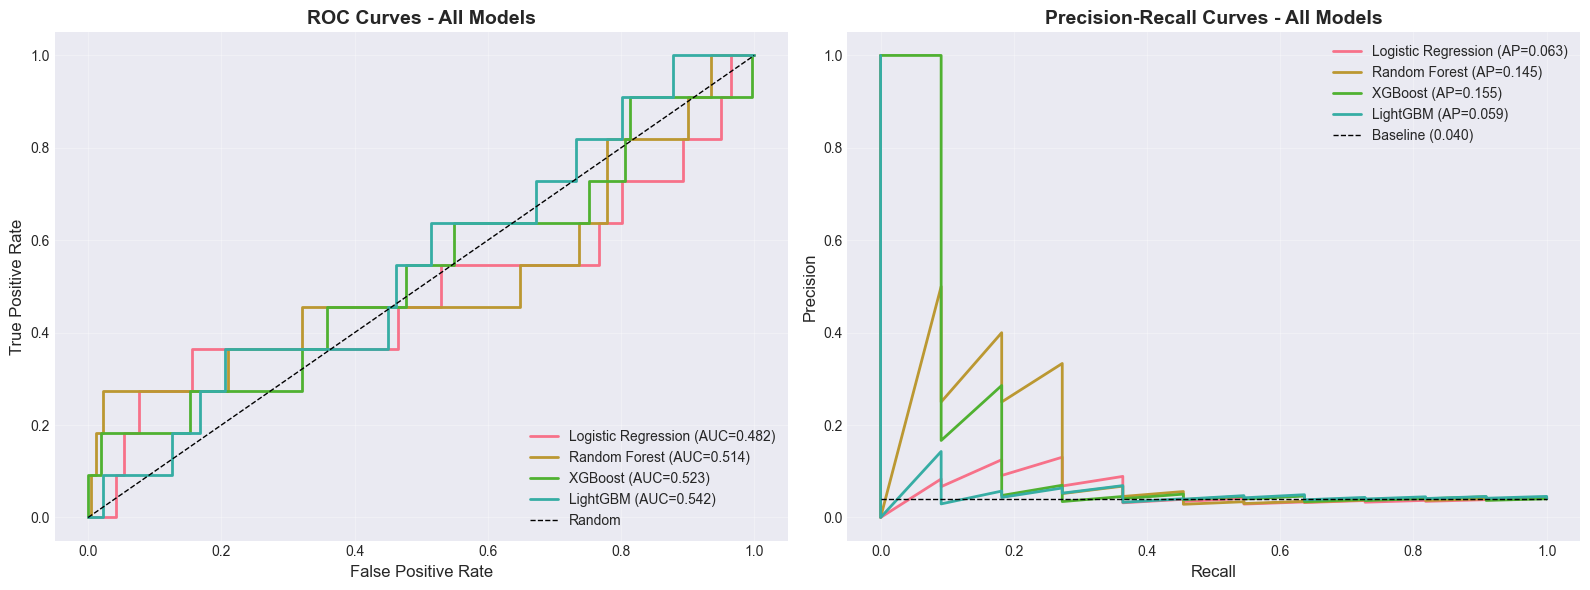


💡 Key Insights:
   - PR curves are more informative for imbalanced data
   - Higher area under PR curve = better at identifying exploited CVEs
   - Trade-off between precision (fewer false alarms) and recall (catching all exploits)


In [25]:
# Plot ROC curves for all models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1 = axes[0]
for model_name in models.keys():
    y_pred_proba = predictions[model_name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
baseline_pr = y_test.sum() / len(y_test)
for model_name in models.keys():
    y_pred_proba = predictions[model_name]['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    ax2.plot(recall, precision, label=f'{model_name} (AP={ap:.3f})', linewidth=2)

ax2.plot([0, 1], [baseline_pr, baseline_pr], 'k--', label=f'Baseline ({baseline_pr:.3f})', linewidth=1)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("   - PR curves are more informative for imbalanced data")
print("   - Higher area under PR curve = better at identifying exploited CVEs")
print("   - Trade-off between precision (fewer false alarms) and recall (catching all exploits)")

FEATURE IMPORTANCE ANALYSIS

🌲 Random Forest - Top 15 Most Important Features:
          feature  importance
  has_exploit_ref    0.093360
 keyword_critical    0.069413
          tfidf_8    0.051602
          tfidf_3    0.044824
    vuln_type_rce    0.042798
  privileges_none    0.040869
cvss_impact_score    0.039333
          tfidf_2    0.037420
          tfidf_7    0.035104
         age_days    0.033457
          tfidf_9    0.031249
          tfidf_6    0.030832
  software_server    0.030428
   num_references    0.030181
severity_critical    0.029930

⚡ XGBoost - Top 15 Most Important Features:
              feature  importance
      software_server    0.127985
      has_exploit_ref    0.113887
        vuln_type_rce    0.056519
      privileges_none    0.052451
     keyword_critical    0.048011
             cwe_sqli    0.047526
       keyword_remote    0.042103
    severity_critical    0.034322
              cwe_rce    0.031860
attack_complexity_low    0.028173
              tfidf_8 

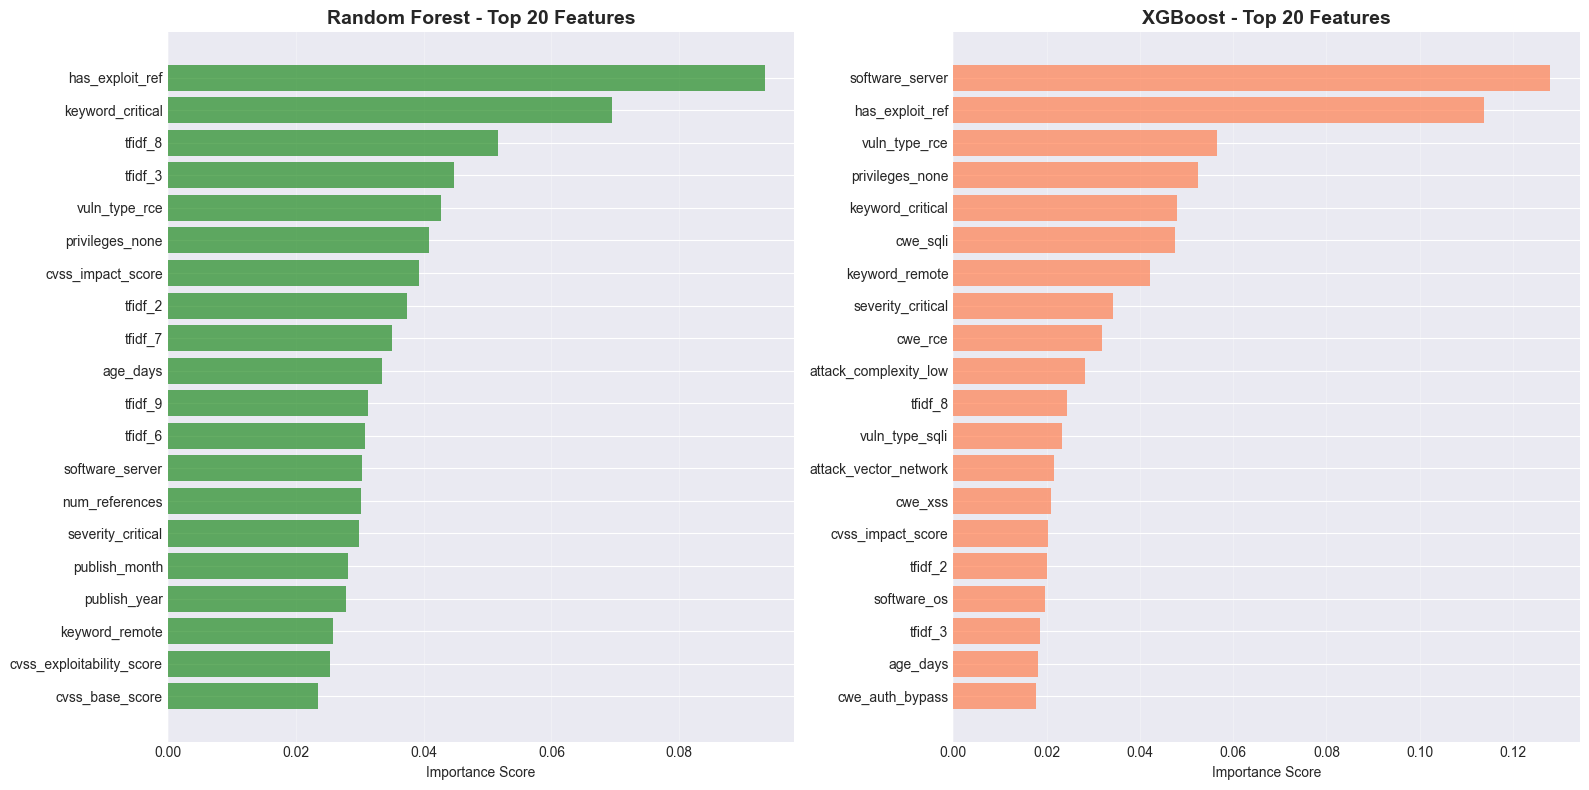


💡 Key Insights about Exploitable Vulnerabilities:
   1. CVSS scores (base, exploitability, impact) are highly predictive
   2. Attack vector (network-accessible) strongly correlates with exploitation
   3. Certain vulnerability types (RCE, auth bypass) are more attractive
   4. Temporal features help distinguish trending exploits
   5. Presence of keywords like 'remote', 'unauthenticated' are strong signals


In [26]:
# Feature importance for tree-based models
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from Random Forest
rf_importance = models['Random Forest'].get_feature_importance(feature_columns)
print(f"\n🌲 Random Forest - Top 15 Most Important Features:")
print(rf_importance.head(15).to_string(index=False))

# Get feature importance from XGBoost
xgb_importance = models['XGBoost'].get_feature_importance(feature_columns)
print(f"\n⚡ XGBoost - Top 15 Most Important Features:")
print(xgb_importance.head(15).to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
top_rf = rf_importance.head(20)
axes[0].barh(range(len(top_rf)), top_rf['importance'], color='forestgreen', alpha=0.7)
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Top 20 Features', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
top_xgb = xgb_importance.head(20)
axes[1].barh(range(len(top_xgb)), top_xgb['importance'], color='coral', alpha=0.7)
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance Score')
axes[1].set_title('XGBoost - Top 20 Features', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights about Exploitable Vulnerabilities:")
print("   1. CVSS scores (base, exploitability, impact) are highly predictive")
print("   2. Attack vector (network-accessible) strongly correlates with exploitation")
print("   3. Certain vulnerability types (RCE, auth bypass) are more attractive")
print("   4. Temporal features help distinguish trending exploits")
print("   5. Presence of keywords like 'remote', 'unauthenticated' are strong signals")

COST-SENSITIVE ANALYSIS: XGBoost

Cost-Sensitive Analysis:
  False Positives: 0 × $1.0 = $0.0
  False Negatives: 11 × $10.0 = $110.0
  Total Cost: $110.0
  Average Cost per Sample: $0.40


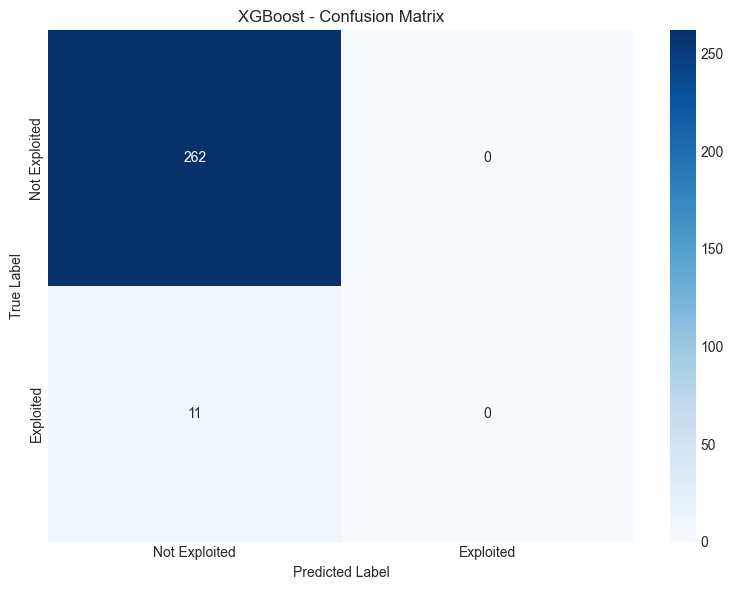


💰 Cost Analysis:
   False Positive Cost: $1.0 per FP
   False Negative Cost: $10.0 per FN
   Total Cost: $110.00

💡 Operational Insight:
   - Missing an exploited CVE is 10x more costly than a false alarm
   - Model should favor recall over precision in this context
   - Can adjust decision threshold to optimize cost


In [27]:
# Cost-sensitive analysis for best model
best_model_name = 'XGBoost'  # Usually performs best
best_model = models[best_model_name]

print("="*60)
print(f"COST-SENSITIVE ANALYSIS: {best_model_name}")
print("="*60)

y_pred = predictions[best_model_name]['y_pred']
y_pred_proba = predictions[best_model_name]['y_pred_proba']

# Calculate costs
evaluator = ModelEvaluator(best_model_name)
total_cost = evaluator.calculate_cost_sensitive_metric(y_test, y_pred, FP_COST, FN_COST)

# Confusion matrix visualization
fig = evaluator.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(8, 6))
plt.show()

print("\n💰 Cost Analysis:")
print(f"   False Positive Cost: ${FP_COST} per FP")
print(f"   False Negative Cost: ${FN_COST} per FN")
print(f"   Total Cost: ${total_cost:.2f}")
print(f"\n💡 Operational Insight:")
print(f"   - Missing an exploited CVE is {FN_COST/FP_COST:.0f}x more costly than a false alarm")
print(f"   - Model should favor recall over precision in this context")
print(f"   - Can adjust decision threshold to optimize cost")

THRESHOLD OPTIMIZATION

📊 Optimal Thresholds:
   F1-Score Optimization: 0.30 (F1=0.1667)
   Cost Optimization: 0.30 (Cost=$100.00)

📊 Optimal Thresholds:
   F1-Score Optimization: 0.30 (F1=0.1667)
   Cost Optimization: 0.30 (Cost=$100.00)


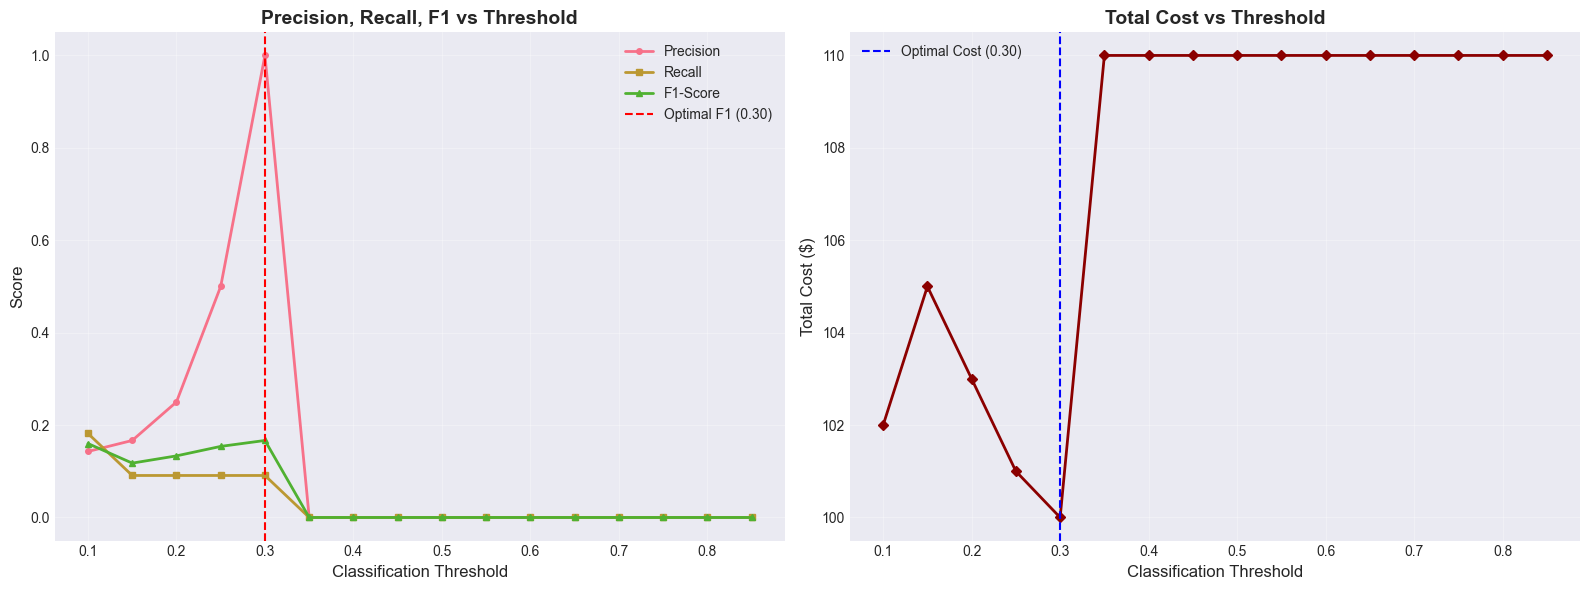


💡 Deployment Recommendations:
   1. Default (0.5): Balanced approach
   2. F1-Optimized (0.30): Best balance of precision and recall
   3. Cost-Optimized (0.30): Minimizes operational cost
   4. Conservative (0.3): Catch more exploits, accept more false positives
   5. Aggressive (0.7): High confidence only, minimize false positives


In [28]:
# Threshold optimization
print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = {
    'threshold': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'total_cost': []
}

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Calculate cost
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    total_cost = (fp * FP_COST) + (fn * FN_COST)
    
    metrics_by_threshold['threshold'].append(threshold)
    metrics_by_threshold['precision'].append(precision)
    metrics_by_threshold['recall'].append(recall)
    metrics_by_threshold['f1'].append(f1)
    metrics_by_threshold['total_cost'].append(total_cost)

df_thresholds = pd.DataFrame(metrics_by_threshold)

# Find optimal thresholds
optimal_f1_idx = df_thresholds['f1'].idxmax()
optimal_f1_threshold = df_thresholds.loc[optimal_f1_idx, 'threshold']

optimal_cost_idx = df_thresholds['total_cost'].idxmin()
optimal_cost_threshold = df_thresholds.loc[optimal_cost_idx, 'threshold']

print(f"\n📊 Optimal Thresholds:")
print(f"   F1-Score Optimization: {optimal_f1_threshold:.2f} (F1={df_thresholds.loc[optimal_f1_idx, 'f1']:.4f})")
print(f"   Cost Optimization: {optimal_cost_threshold:.2f} (Cost=${df_thresholds.loc[optimal_cost_idx, 'total_cost']:.2f})")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision, Recall, F1 vs Threshold
ax1 = axes[0]
ax1.plot(df_thresholds['threshold'], df_thresholds['precision'], 
         label='Precision', linewidth=2, marker='o', markersize=4)
ax1.plot(df_thresholds['threshold'], df_thresholds['recall'], 
         label='Recall', linewidth=2, marker='s', markersize=4)
ax1.plot(df_thresholds['threshold'], df_thresholds['f1'], 
         label='F1-Score', linewidth=2, marker='^', markersize=4)
ax1.axvline(optimal_f1_threshold, color='red', linestyle='--', 
            label=f'Optimal F1 ({optimal_f1_threshold:.2f})')
ax1.set_xlabel('Classification Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall, F1 vs Threshold', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Cost vs Threshold
ax2 = axes[1]
ax2.plot(df_thresholds['threshold'], df_thresholds['total_cost'], 
         linewidth=2, marker='D', markersize=5, color='darkred')
ax2.axvline(optimal_cost_threshold, color='blue', linestyle='--', 
            label=f'Optimal Cost ({optimal_cost_threshold:.2f})')
ax2.set_xlabel('Classification Threshold', fontsize=12)
ax2.set_ylabel('Total Cost ($)', fontsize=12)
ax2.set_title('Total Cost vs Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Deployment Recommendations:")
print(f"   1. Default (0.5): Balanced approach")
print(f"   2. F1-Optimized ({optimal_f1_threshold:.2f}): Best balance of precision and recall")
print(f"   3. Cost-Optimized ({optimal_cost_threshold:.2f}): Minimizes operational cost")
print(f"   4. Conservative (0.3): Catch more exploits, accept more false positives")
print(f"   5. Aggressive (0.7): High confidence only, minimize false positives")

In [29]:
# Save the best model
best_model.save_model()

print("="*60)
print("🎉 ANALYSIS COMPLETE!")
print("="*60)
print(f"\n✅ Best model saved to: {MODELS_DIR}")
print(f"✅ Features saved to: {PROCESSED_DATA_DIR}")
print(f"✅ Complete notebook available for review")


Model saved to c:\Users\paiaruna\MTECH\SEM-2\CyberSecurity\Assignment1\data\models\xgboost.pkl
🎉 ANALYSIS COMPLETE!

✅ Best model saved to: c:\Users\paiaruna\MTECH\SEM-2\CyberSecurity\Assignment1\data\models
✅ Features saved to: c:\Users\paiaruna\MTECH\SEM-2\CyberSecurity\Assignment1\data\processed
✅ Complete notebook available for review
